In [1]:
%matplotlib inline


# YOLO/PASCAL-VOC detection tutorial

This tutorial demonstrates that Akida can perform object detection. This is illustrated using a
subset of the
[PASCAL-VOC 2007 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/htmldoc/index.html)_
which contains 20 classes. The YOLOv2 architecture from
[Redmon et al (2016)](https://arxiv.org/pdf/1506.02640.pdf) has been chosen to
tackle this object detection problem.


## 1. Introduction



### 1.1 Object detection

Object detection is a computer vision task that combines two elemental tasks:

 - object classification that consists in assigning a class label to an image
   like shown in the [AkidaNet/ImageNet inference](./plot_1_akidanet_imagenet.html)
   example
 - object localization that consists of drawing a bounding box around one or
   several objects in an image

One can learn more about the subject by reading this [introduction to object
detection blog article](https://machinelearningmastery.com/object-recognition-with-deep-learning/).




### 1.2 YOLO key concepts

You Only Look Once (YOLO) is a deep neural network architecture dedicated to
object detection.

As opposed to classic networks that handle object detection, YOLO predicts
bounding boxes (localization task) and class probabilities (classification
task) from a single neural network in a single evaluation. The object
detection task is reduced to a regression problem to spatially separated boxes
and associated class probabilities.

YOLO base concept is to divide an input image into regions, forming a grid,
and to predict bounding boxes and probabilities for each region. The bounding
boxes are weighted by the prediction probabilities.

YOLO also uses the concept of "anchors boxes" or "prior boxes". The network
does not actually predict the actual bounding boxes but offsets from anchors
boxes which are templates (width/height ratio) computed by clustering the
dimensions of the ground truth boxes from the training dataset. The anchors
then represent the average shape and size of the objects to detect. More
details on the anchors boxes concept are given in [this blog article](https://medium.com/@andersasac/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9).

Additional information about YOLO can be found on the [Darknet website](https://pjreddie.com/darknet/yolov2/) and source code for the preprocessing
and postprocessing functions that are included in akida_models package (see
the [processing section](../../api_reference/akida_models_apis.html#processing)
in the model zoo) is largely inspired from
[experiencor github](https://github.com/experiencor/keras-yolo2).




## 2. Preprocessing tools

A subset of VOC has been prepared with test images from VOC2007
that contains 5 examples of each class. The dataset is represented as
a tfrecord file, containing images, labels, and bounding boxes.

The `load_tf_dataset` function is a helper function that facilitates the loading
and parsing of the tfrecord file.

The [YOLO toolkit](../../api_reference/akida_models_apis.html#yolo-toolkit)
offers several methods to prepare data for processing, see
[load_image](../../api_reference/akida_models_apis.html#akida_models.detection.processing.load_image),
[preprocess_image](../../api_reference/akida_models_apis.html#akida_models.detection.processing.preprocess_image).





In [2]:
import tensorflow as tf

from akida_models import fetch_file

# Download TFrecords test set from Brainchip data server
data_path = fetch_file(
    fname="voc_test_20_classes.tfrecord",
    origin="https://data.brainchip.com/dataset-mirror/voc/test_20_classes.tfrecord",
    cache_subdir='datasets/voc',
    extract=True)


# Helper function to load and parse the Tfrecord file.
def load_tf_dataset(tf_record_file_path):
    tfrecord_files = [tf_record_file_path]

    # Feature description for parsing the TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'objects/bbox': tf.io.VarLenFeature(tf.float32),
        'objects/label': tf.io.VarLenFeature(tf.int64),
    }

    def _count_tfrecord_examples(dataset):
        return len(list(dataset.as_numpy_iterator()))

    def _parse_tfrecord_fn(example_proto):
        example = tf.io.parse_single_example(example_proto, feature_description)

        # Decode the image from bytes
        example['image'] = tf.io.decode_jpeg(example['image'], channels=3)

        # Convert the VarLenFeature to a dense tensor
        example['objects/label'] = tf.sparse.to_dense(example['objects/label'], default_value=0)

        example['objects/bbox'] = tf.sparse.to_dense(example['objects/bbox'])
        # Boxes were flattenned that's why we need to reshape them
        example['objects/bbox'] = tf.reshape(example['objects/bbox'],
                                             (tf.shape(example['objects/label'])[0], 4))
        # Create a new dictionary structure
        objects = {
            'label': example['objects/label'],
            'bbox': example['objects/bbox'],
        }

        # Remove unnecessary keys
        example.pop('objects/label')
        example.pop('objects/bbox')

        # Add 'objects' key to the main dictionary
        example['objects'] = objects

        return example

    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    len_dataset = _count_tfrecord_examples(dataset)
    parsed_dataset = dataset.map(_parse_tfrecord_fn)

    return parsed_dataset, len_dataset


labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
          'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
          'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
          'train', 'tvmonitor']

val_dataset, len_val_dataset = load_tf_dataset(data_path)
print(f"Loaded VOC2007 sample test data: {len_val_dataset} images.")

2025-07-23 12:33:07.247149: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 12:33:07.303811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-23 12:33:07.303860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-23 12:33:07.306088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 12:33:07.319742: I tensorflow/core/platform/cpu_feature_guar

Loaded VOC2007 sample test data: 100 images.


Anchors can also be computed easily using YOLO toolkit.

.. Note:: The following code is given as an example. In a real use case
          scenario, anchors are computed on the training dataset.



In [3]:
from akida_models.detection.generate_anchors import generate_anchors

num_anchors = 5
grid_size = (7, 7)
anchors_example = generate_anchors(val_dataset, num_anchors, grid_size)


Average IOU for 5 anchors: 0.70
Anchors:  [[1.09978, 1.95618], [2.08917, 2.70746], [3.01758, 3.48136], [4.53886, 5.3882], [5.28039, 5.54529]]


## 3. Model architecture

The [model zoo](../../api_reference/akida_models_apis.html#yolo) contains a
YOLO model that is built upon the [AkidaNet architecture](../../api_reference/akida_models_apis.html#akida_models.akidanet_imagenet)
and 3 separable convolutional layers at the top for bounding box and class
estimation followed by a final separable convolutional which is the detection
layer. Note that for efficiency, the alpha parameter in AkidaNet (network
width or number of filter in each layer) is set to 0.5.




In [4]:
from akida_models import yolo_base

# Create a yolo model for 20 classes with 5 anchors and grid size of 7
classes = len(labels)

model = yolo_base(input_shape=(224, 224, 3),
                  classes=classes,
                  nb_box=num_anchors,
                  alpha=0.5)
model.summary()

Model: "yolo_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 112, 112, 16)      432       
                                                                 
 conv_0/BN (BatchNormalizat  (None, 112, 112, 16)      64        
 ion)                                                            
                                                                 
 conv_0/relu (ReLU)          (None, 112, 112, 16)      0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 32)      4608      
                                                         

The model output can be reshaped to a more natural shape of:

 (grid_height, grid_width, anchors_box, 4 + 1 + num_classes)

where the "4 + 1" term represents the coordinates of the estimated bounding
boxes (top left x, top left y, width and height) and a confidence score. In
other words, the output channels are actually grouped by anchor boxes, and in
each group one channel provides either a coordinate, a global confidence score
or a class confidence score. This process is done automatically in the
[decode_output](../../api_reference/akida_models_apis.html#akida_models.detection.processing.decode_output)_
function.



In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Reshape

# Define a reshape output to be added to the YOLO model
output = Reshape((grid_size[1], grid_size[0], num_anchors, 4 + 1 + classes),
                 name="YOLO_output")(model.output)

# Build the complete model
full_model = Model(model.input, output)
full_model.output

<KerasTensor: shape=(None, 7, 7, 5, 25) dtype=float32 (created by layer 'YOLO_output')>

## 4. Training

As the YOLO model relies on Brainchip AkidaNet/ImageNet network, it is
possible to perform transfer learning from ImageNet pretrained weights when
training a YOLO model. See the [PlantVillage transfer learning example](./plot_4_transfer_learning.html) for a detail explanation on transfer
learning principles.
Additionally, for achieving optimal results, consider the following approach:

1. Initially, train the model on the COCO dataset. This process helps in learning
general object detection features and improves the model's ability to detect various
objects across different contexts.

2. After training on COCO, transfer the learned weights to a model equipped with a
VOC head.

3. Fine-tune the transferred weights on the VOC dataset. This step allows the model
to adapt to the specific characteristics and nuances of the VOC dataset, further
enhancing its performance on VOC-related tasks.




## 5. Performance

The model zoo also contains an [helper method](../../api_reference/akida_models_apis.html#akida_models.yolo_voc_pretrained)
that allows to create a YOLO model for VOC and load pretrained weights for the
detection task and the corresponding anchors. The anchors are used to interpret
the model outputs.

The metric used to evaluate YOLO is the mean average precision (mAP) which is
the percentage of correct prediction and is given for an intersection over
union (IoU) ratio. Scores in this example are given for the standard IoU of
0.5, meaning that a detection is considered valid if the intersection over union
ratio with its ground truth equivalent is above 0.5 (mAP 50).

 .. Note:: A call to [evaluate_map](../../api_reference/akida_models_apis.html#akida_models.detection.map_evaluation.MapEvaluation.evaluate_map)
           will preprocess the images, make the call to ``Model.predict`` and
           use [decode_output](../../api_reference/akida_models_apis.html#akida_models.detection.processing.decode_output)_
           before computing precision for all classes.




In [6]:
from timeit import default_timer as timer
from akida_models import yolo_voc_pretrained
from akida_models.detection.map_evaluation import MapEvaluation

# Load the pretrained model along with anchors
model_keras, anchors = yolo_voc_pretrained()
model_keras.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (QuantizedRescal  (None, 224, 224, 3)       0         
 ing)                                                            
                                                                 
 conv_0 (QuantizedConv2D)    (None, 112, 112, 16)      448       
                                                                 
 conv_0/relu (QuantizedReLU  (None, 112, 112, 16)      32        
 )                                                               
                                                                 
 conv_1 (QuantizedConv2D)    (None, 112, 112, 32)      4640      
                                                                 
 conv_1/relu (QuantizedReLU  (None, 112, 112, 32)      64  

In [7]:
# Define the final reshape and build the model
output = Reshape((grid_size[1], grid_size[0], num_anchors, 4 + 1 + classes),
                 name="YOLO_output")(model_keras.output)
model_keras = Model(model_keras.input, output)

# Create the mAP evaluator object
map_evaluator = MapEvaluation(model_keras, val_dataset,
                              len_val_dataset, labels, anchors)

# Compute the scores for all validation images
start = timer()

map_dict, average_precisions = map_evaluator.evaluate_map()
mAP = sum(map_dict.values()) / len(map_dict)
end = timer()

for label, average_precision in average_precisions.items():
    print(labels[label], '{:.4f}'.format(average_precision))
print('mAP 50: {:.4f}'.format(map_dict[0.5]))
print(f'Keras inference on {len_val_dataset} images took {end-start:.2f} s.\n')

Getting predictions:   0%|          | 0/130 [00:00<?, ?it/s]2025-07-23 12:33:53.268197: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_1/conv_0/aligned_weight_quantizer/assert_less/Assert/AssertGuard/branch_executed/_25
                                                                                         

aeroplane 0.7733
bicycle 0.5278
bird 0.5208
boat 0.3100
bottle 0.3783
bus 0.8013
car 0.8444
cat 0.7760
chair 0.3014
cow 0.4717
diningtable 0.4639
dog 0.4384
horse 0.5596
motorbike 0.5764
person 0.4690
pottedplant 0.0893
sheep 0.4708
sofa 0.5850
train 0.6136
tvmonitor 0.5860
mAP 50: 0.8783
Keras inference on 100 images took 25.66 s.



## 6. Conversion to Akida



### 6.1 Convert to Akida model
The last YOLO_output layer that was added for splitting channels into values
for each box must be removed before Akida conversion.



In [8]:
# Rebuild a model without the last layer
compatible_model = Model(model_keras.input, model_keras.layers[-2].output)

When converting to an Akida model, we just need to pass the Keras model
to [cnn2snn.convert](../../api_reference/cnn2snn_apis.html#convert).




In [9]:
from cnn2snn import convert

model_akida = convert(compatible_model)
model_akida.summary()

2025-07-23 12:34:22.039147: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model/conv_0/aligned_weight_quantizer/assert_less/Assert/AssertGuard/branch_executed/_34


                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [7, 7, 125]   1          33    
________________________________________________

__________________________________________________________________________
Layer (type)                          Output shape    Kernel shape      

==================== SW/conv_0-dequantizer (Software) ====================

conv_0 (InputConv2D)                  [112, 112, 16]  (3, 3, 3, 16)     
__________________________________________________________________________
conv_1 (Conv2D)                       [112, 112, 32]  (3, 3, 16, 32)    
__________________________________________________________________________
conv_2 (Conv2D)                       [56, 56, 64]    (3, 3, 32, 64)    
__________________________________________________________________________
conv_3 (Conv2D)                       [56, 56, 64]    (3, 3, 64, 64)    
________________

### 6.1 Check performance

Akida model accuracy is tested on the first *n* images of the validation set.




In [10]:
# Create the mAP evaluator object
map_evaluator_ak = MapEvaluation(model_akida,
                                 val_dataset,
                                 len_val_dataset,
                                 labels,
                                 anchors,
                                 is_keras_model=False)

# Compute the scores for all validation images
start = timer()
map_ak_dict, average_precisions_ak = map_evaluator_ak.evaluate_map()
mAP_ak = sum(map_ak_dict.values()) / len(map_ak_dict)
end = timer()

for label, average_precision in average_precisions_ak.items():
    print(labels[label], '{:.4f}'.format(average_precision))
print('mAP 50: {:.4f}'.format(map_ak_dict[0.5]))
print(f'Akida inference on {len_val_dataset} images took {end-start:.2f} s.\n')

aeroplane 0.7733
bicycle 0.5278
bird 0.5208
boat 0.3100
bottle 0.3783
bus 0.8013
car 0.8444
cat 0.7760
chair 0.3014
cow 0.4717
diningtable 0.4639
dog 0.4384
horse 0.5596
motorbike 0.5764
person 0.4690
pottedplant 0.0893
sheep 0.4708
sofa 0.5850
train 0.6136
tvmonitor 0.5860
mAP 50: 0.8783
Akida inference on 100 images took 11.54 s.



In [12]:
import akida
from cnn2snn import set_akida_version, AkidaVersion
# Instantiate akida model
with set_akida_version(AkidaVersion.v2):
    devices = akida.devices()
    if len(devices) > 0:
        print(f'Available devices: {[dev.desc for dev in devices]}')
        device = devices[0]
        print(device.version)
        try:
            model_akida.map(device)
            print(f"Mapping to Akida device {device.desc}.")
        except Exception as e:
            print("Model not compatible with FPGA. Running on CPU.")
    else:
        print("No Akida devices found, running on CPU.")


No Akida devices found, running on CPU.


### 6.2 Show predictions for a random image




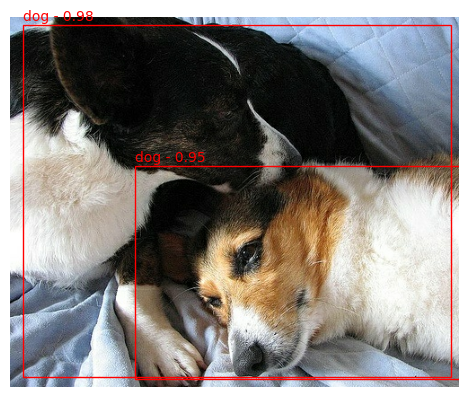

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from akida_models.detection.processing import preprocess_image, decode_output

# Shuffle the data to take a random test image
val_dataset = val_dataset.shuffle(buffer_size=len_val_dataset)

input_shape = model_akida.layers[0].input_dims

# Load the image
raw_image = next(iter(val_dataset))['image']

# Keep the original image size for later bounding boxes rescaling
raw_height, raw_width, _ = raw_image.shape

# Pre-process the image
image = preprocess_image(raw_image, input_shape)
input_image = image[np.newaxis, :].astype(np.uint8)

# Call evaluate on the image
pots = model_akida.predict(input_image)[0]

# Reshape the potentials to prepare for decoding
h, w, c = pots.shape
pots = pots.reshape((h, w, len(anchors), 4 + 1 + len(labels)))

# Decode potentials into bounding boxes
raw_boxes = decode_output(pots, anchors, len(labels))

# Rescale boxes to the original image size
pred_boxes = np.array([[
    box.x1 * raw_width, box.y1 * raw_height, box.x2 * raw_width,
    box.y2 * raw_height,
    box.get_label(),
    box.get_score()
] for box in raw_boxes])

fig = plt.figure(num='VOC detection by Akida')
ax = fig.subplots(1)
img_plot = ax.imshow(np.zeros(raw_image.shape, dtype=np.uint8))
img_plot.set_data(raw_image)

for box in pred_boxes:
    rect = patches.Rectangle((box[0], box[1]),
                             box[2] - box[0],
                             box[3] - box[1],
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)
    class_score = ax.text(box[0],
                          box[1] - 5,
                          f"{labels[int(box[4])]} - {box[5]:.2f}",
                          color='red')

plt.axis('off')
plt.show()